<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(2)_DA_diffxpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import preprocessed Anndata object for four biological replicates, SRR26046013 (cells treated with AOA inhibitor), SRR26046015 (cells treated with DON inhibitor), SRR26046017 (cells treated with DG inhibitor), and SRR26046019 (untreated cells).
Following steps were performed in the preprocessing:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [1]:
!pip install -q condacolab

In [2]:
import condacolab

In [3]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.11.0


In [5]:
!which conda

/usr/local/bin/conda


In [6]:
!conda config --add channels conda-forge

In [7]:
!conda config --add channels bioconda

In [8]:
!pip install snapatac2 -q

In [9]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [10]:
import snapatac2 as snap

In [11]:
!pip install umap-learn



In [12]:
import umap.umap_ as umap


In [13]:
from umap import UMAP

In [14]:
!pip install scanpy -q

In [15]:
import scanpy as sc

In [16]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [17]:
import numpy as np

In [18]:
import anndata as ad

In [19]:
!pip install diffxpy -q

In [20]:
!pip install scikit-misc -q

In [21]:
import diffxpy.api as de

In [22]:
import matplotlib.pyplot as plt

In [23]:
import seaborn as sns

In [24]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [25]:
from scipy import stats

In [26]:
import pandas as pd

# Import reads from google drive, three samples treated with energy metabolism inhibitors and one untreated

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Load AD matrix from google drive, PCA and Batch corrected
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Make observation names unique



In [29]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

In [30]:
# Check if any gene names are duplicated
has_duplicates = adata_concat.var_names.duplicated().any()

if has_duplicates:
    print("var_names are not unique.")
else:
    print("var_names are unique.")

var_names are unique.


In [31]:
# Check if the number of unique gene names is equal to the total number of gene names
is_unique = len(adata_concat.var_names) == pd.Series(adata_concat.var_names).nunique()

if is_unique:
    print("var_names are unique.")
else:
    print("var_names are not unique.")

var_names are unique.


In [32]:
# Check if any observations are duplicated
has_duplicates = adata_concat.obs_names.duplicated().any()

if has_duplicates:
    print("Observations are not unique.")
else:
    print("Observations are unique.")

Observations are not unique.


In [33]:
# Check if the number of unique observations is equal to the total number of observations
is_unique = len(adata_concat.obs_names) == pd.Series(adata_concat.obs_names).nunique()

if is_unique:
    print("Observations are unique.")
else:
    print("Observations are not unique.")

Observations are not unique.


In [34]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'ENSG00000238009', 'ENSG00000239945', 'DDX11L17',
       'WASH9P', 'ENSG00000228463', 'ENSG00000286448', 'U6', 'ENSG00000230021',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53017)

In [35]:
#Create unique observation names
experiment_names = ["Treated w/AOA", "Treated w/DON", "Treated w/DG", "Untreated"]

# Create a new column to store combined barcode and treatment information
adata_concat.obs['barcode_treatment'] = adata_concat.obs_names.astype(str)

# Modify the 'barcode_treatment' column
for i, treatment in enumerate(experiment_names):
    cell_indices = adata_concat.obs.index[adata_concat.obs["Treatment"] == treatment]
    adata_concat.obs.loc[cell_indices, 'barcode_treatment'] = adata_concat.obs.loc[cell_indices, 'barcode_treatment'] + "_" + str(i + 1)

In [36]:
#Set 'barcode_treatment' as the new index:
adata_concat.obs_names = pd.Index(adata_concat.obs['barcode_treatment'])

In [37]:
adata_concat.obs

,n_fragment,frac_dup,frac_mito,tsse,doublet_probability,doublet_score,leiden,Treatment,barcode_treatment
barcode_treatment,,,,,,,,,
AAACAACGAACGAGCA_1,20919,0.502426,0.000096,25.061425,0.052336,0.047059,7,Treated w/AOA,AAACAACGAACGAGCA_1
AAACAACGAAGAGGCT_1,13308,0.488184,0.000826,23.198793,0.066163,0.009174,4,Treated w/AOA,AAACAACGAAGAGGCT_1
AAACAACGAAGTCGGA_1,17302,0.502830,0.000058,18.234291,0.061446,0.015294,5,Treated w/AOA,AAACAACGAAGTCGGA_1
AAACAACGAGAAGGCT_1,14109,0.530246,0.000071,29.930591,0.070621,0.004525,0,Treated w/AOA,AAACAACGAGAAGGCT_1
AAACAACGAGTACGTT_1,12165,0.588867,0.000000,21.409091,0.062457,0.013841,7,Treated w/AOA,AAACAACGAGTACGTT_1
...,...,...,...,...,...,...,...,...,...
TTTGGGATGAACGTAA_4,33918,0.336626,0.001766,18.594706,0.185808,0.043189,1,Untreated,TTTGGGATGAACGTAA_4
TTTGGGATGAAGTCTC_4,25630,0.307834,0.000117,15.581623,0.221046,0.025360,7,Untreated,TTTGGGATGAAGTCTC_4
TTTGGGATGATGTGGG_4,28438,0.336774,0.001019,19.425019,0.189493,0.040388,0,Untreated,TTTGGGATGATGTGGG_4


# Differential accessibility analysis using diffxpy

In [38]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

In [39]:
import dask.array as da

In [40]:
import scipy.sparse as sparse

In [41]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment', 'barcode_treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

# Run diffxpy wald test

In [42]:
# Filter mitochondrial genes before highly variable gene selection
adata_concat.var['mt'] = adata_concat.var_names.str.startswith('MT-')
adata_filtered = adata_concat[:, ~adata_concat.var['mt']]

In [43]:
# Calculate highly variable features
sc.pp.highly_variable_genes(adata_filtered, flavor='seurat', batch_key="Treatment")

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
... storing 'barcode_treatment' as categorical


In [44]:
adata_filtered.var

,mt,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
DDX11L1,False,False,0.002310,-6.608040,-0.867527,0,False
WASH7P,False,False,0.005880,-6.490140,-0.761338,0,False
ENSG00000238009,False,False,0.004509,-6.068085,-0.347287,0,False
ENSG00000239945,False,False,0.002125,-6.346975,-0.622137,0,False
DDX11L17,False,False,0.010920,-6.073543,-0.346520,0,False
...,...,...,...,...,...,...,...
RBMY2FP,False,False,0.001696,-5.899362,-0.188919,0,False
PPP1R12BP1,False,False,0.006008,-6.713754,-0.956325,0,False
ANKRD36P1,False,False,0.002000,-6.854659,-1.084179,0,False
TPTE2P4,False,False,0.007267,-5.680059,0.023340,0,False


Dispersion_norm represents the normalized dispersion of each gene.
Dispersion is a measure of how spread out the expression of a gene is across different cells.
Normalization adjusts the dispersion values to account for the relationship between mean expression and dispersion, ensuring that genes with similar mean expression levels are compared fairly.
Higher values of dispersions_norm indicate genes with higher variability or dispersion.
Dispersions_norm is a key factor used for ranking highly variable genes.
Genes with higher dispersions_norm values are considered more variable and are ranked higher.

In [45]:
# Create a new 'highly_variable_rank' column
adata_filtered.var['highly_variable_rank'] = adata_filtered.var['dispersions_norm'].rank(ascending=False)

In [46]:
# Sort genes by 'highly_variable_rank' in ascending order (lower rank = more variable)
adata_filtered.var = adata_filtered.var.sort_values(by='highly_variable_rank')

In [47]:
# Print or access the ranked genes
adata_filtered.var

,mt,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,highly_variable_rank
BCL11B,False,True,0.799900,1.266376,5.293401,4,True,1.0
CD3D,False,True,0.118995,-0.495147,4.805953,4,True,2.0
MTATP6P1,False,True,0.055339,-0.819092,4.705988,4,True,3.0
ENSG00000278791,False,True,0.055163,-0.820029,4.705050,4,True,4.0
MTCO3P12,False,True,0.055379,-0.822619,4.702324,4,True,5.0
...,...,...,...,...,...,...,...,...
ENSG00000254610,False,False,0.153107,-5.845541,-2.053818,0,False,52976.0
NCOA2,False,False,1.365985,-3.723416,-2.104039,0,False,52977.0
ELF2,False,False,1.245995,-3.899111,-2.112438,0,False,52978.0
TBRG1,False,False,0.207018,-5.959982,-2.178973,0,False,52979.0


In [48]:
# Subsample features (e.g., top 1000 highly variable genes)
adata_subset = adata_filtered[:, adata_filtered.var.index[:1000]] # Select the top 1000 genes

In [49]:
adata_subset.var

,mt,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,highly_variable_rank
BCL11B,False,True,0.799900,1.266376,5.293401,4,True,1.0
CD3D,False,True,0.118995,-0.495147,4.805953,4,True,2.0
MTATP6P1,False,True,0.055339,-0.819092,4.705988,4,True,3.0
ENSG00000278791,False,True,0.055163,-0.820029,4.705050,4,True,4.0
MTCO3P12,False,True,0.055379,-0.822619,4.702324,4,True,5.0
...,...,...,...,...,...,...,...,...
ENSG00000287216,False,True,0.187581,-2.192403,2.187372,4,True,996.0
MIR655,False,True,0.016074,-3.486210,2.187321,3,False,997.0
RUBCNL,False,True,0.520087,-1.850596,2.186599,4,True,998.0
IDO2,False,True,0.351006,-2.130150,2.185780,4,True,999.0


# Perform t-test

In [50]:
test_tt = de.test.t_test(
    data=adata_subset,
    grouping="Treatment"
)

In [51]:
test_tt.summary()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,BCL11B,1.860436e-186,2.238792e-186,0.724020,0.002121,False,False
1,CD3D,0.000000e+00,0.000000e+00,1.022222,0.005669,False,False
2,MTATP6P1,6.656099e-147,7.721692e-147,0.688174,0.004294,False,False
3,ENSG00000278791,4.139208e-02,4.185246e-02,0.059771,0.002004,False,False
4,MTCO3P12,0.000000e+00,0.000000e+00,1.211965,0.008803,False,False
...,...,...,...,...,...,...,...
995,ENSG00000287216,0.000000e+00,0.000000e+00,0.603802,0.399829,False,False
996,MIR655,0.000000e+00,0.000000e+00,0.625423,0.111940,False,False
997,RUBCNL,0.000000e+00,0.000000e+00,0.623364,0.109222,False,False
998,IDO2,0.000000e+00,0.000000e+00,0.673937,0.582492,False,False


<Axes: >

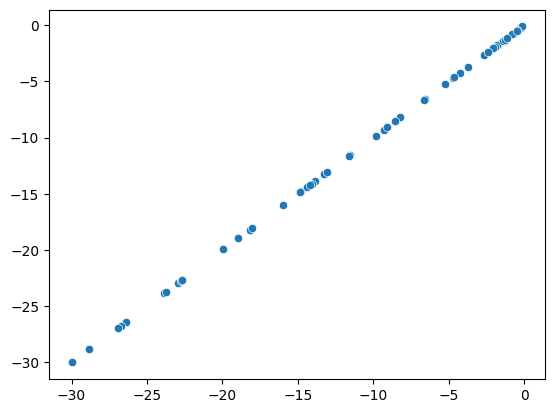

In [52]:
sns.scatterplot(
    x=test_tt.log10_pval_clean(),
    y=test_tt.log10_pval_clean()
)

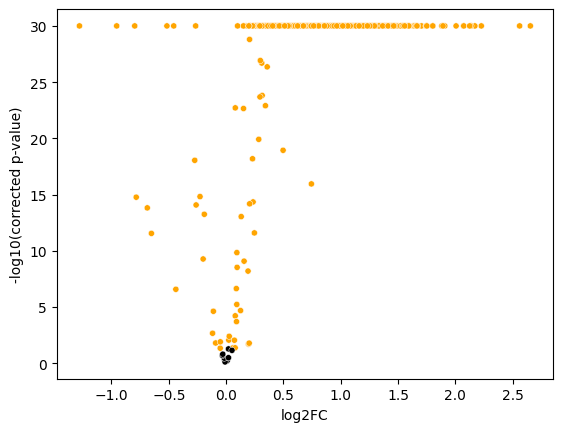

In [53]:
test_tt.plot_volcano()

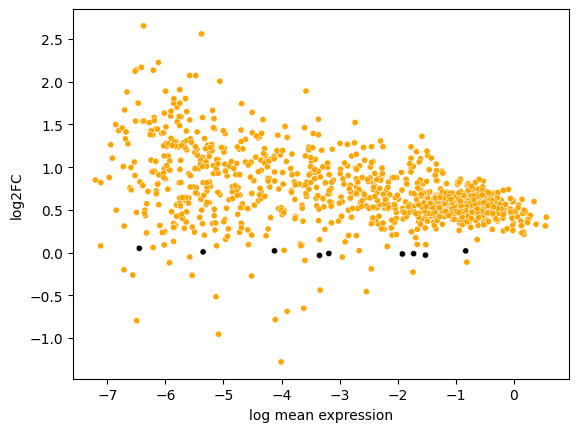

In [54]:
test_tt.plot_ma()